In [1]:
# Setting up google drive 
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#import sys
#sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [2]:
import my_utils as mu
import torch
from torch import nn
from IPython import display
import wandb

wandb.init(project="my-test-project", entity="superaudric")

wandb: Currently logged in as: superaudric (use `wandb login --relogin` to force relogin)


# Defining the Model
* Creates a neural network to accept the number of inputs, outputs and backbone layers.


In [3]:
class Net(torch.nn.Module):        
    def __init__(self, num_inputs, num_outputs,num_backbone,num_hidden):
        super(Net, self).__init__()
        self.num_inputs = num_inputs;
        self.num_outputs = num_outputs;
        self.num_features = int(num_hidden/2);
        self.num_backbone = num_backbone;
        self.testNum=256;
        previous=256;#=int(((num_inputs)**0.5)/2+2)**2;#the count of outputs into the first linear layer
        total_nodes=num_backbone*3+3;#the count of nodes that change the size of their input
        layer_neurons=[previous]+[num_hidden]*(total_nodes-1)+[num_outputs]#generates the number of outputs inbetween any 2 layers
        print(layer_neurons);
        #Add stem
        self.stem_pool = nn.AvgPool2d((2, 2), stride=(2, 2),padding=(1,1),count_include_pad=False);
        self.stem_fltn = nn.Flatten();
        k=0;#counter vatiable used to traverse layer_neurons
        for i in range(0,num_backbone):#Add backbone
            self.add_module('BBlayer{0}LinearA'.format(i), nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=True));
            k+=1;
            temp=layer_neurons[k]
            if (i==0):
                temp=225
            self.add_module('BBlayer{0}LinearB'.format(i), nn.Linear(temp,  layer_neurons[k], bias=True));
            k+=1;
            self.add_module('BBlayer{0}LinearC'.format(i), nn.Linear(layer_neurons[k],  layer_neurons[k], bias=True));
            k+=1;
            self.add_module('BBlayer{0}norm'.format(i), nn.BatchNorm1d(450,affine=True));
        #Add classifier
        self.add_module('classifierA', nn.Linear(layer_neurons[k+1],  layer_neurons[k], bias=True))
        k+=1;
        self.add_module('classifierB', nn.Linear(layer_neurons[k+1],  layer_neurons[k], bias=False))
        k+=1;
        self.add_module('classifierC', nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=False))
    def forward(self, x):
        out=x
        out = self.stem_pool(out);
        #out = self.stem_fltn(out);
        out = out.view(-1, self.num_features);
        for i in range(0,num_backbone):#BackBone
            print("A",out.shape)
            out = torch.transpose(out,1,2);
            out = self._modules['BBlayer{0}LinearA'.format(i)](out)
            print("B",out.shape)
            out = torch.transpose(out,0,1);
            out = nn.functional.silu(out);
            out = self._modules['BBlayer{0}LinearB'.format(i)](out)
            print("C",out.shape)
            out = torch.transpose(out,0,1);
            out = nn.functional.selu(out);
            out = self._modules['BBlayer{0}LinearC'.format(i)](out)
            out = self._modules['BBlayer{0}norm'.format(i)](out)
            print("D",out.shape)
            out = nn.functional.celu(out);
        out = torch.transpose(out,0,1);
        out = self._modules['classifierA'](out);
        out = nn.functional.silu(out);
        out = torch.transpose(out,0,1);
        out = self._modules['classifierB'](out);
        out = nn.functional.relu(out);
        out = torch.transpose(out,0,1);
        out = self._modules['classifierC'](out);
        out = nn.functional.relu6(out);
        return out;

# Weight Initialization

In [4]:
def init_weights(m):#called once in each layer, checks if layertype==Linear, then initializes it to default values
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

# Training

* The training function was rewritten from the myutils default to allow for a scheduler, and an animator with different limits.
* Each epoch, the test accuracy is printed numerically and the updated graph is displayed beneath.

In [5]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,optimizer,decay_rate): 
    animator =mu.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                          legend=['train loss', 'train acc', 'test acc']);
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate);
    for epoch in range(num_epochs):
        train_metrics = mu.train_epoch_ch3(net, train_iter, loss, optimizer);
        test_acc = mu.evaluate_accuracy(net, test_iter);
        print(test_acc);
        animator.add(epoch + 1, train_metrics + (test_acc,));
        scheduler.step();
        wandb.log({"loss": loss})

        # Optional
        wandb.watch(net)

# Main
* Assigns hyper-parameters, and initializes the weights.
* Finally it starts he network training, before evaluating its success

In [6]:
num_inputs, num_outputs, num_hidden = 784, 10, 450;
num_backbone=5;
num_epochs = 100;
batch_size = 256;
learning_rate=1e-4;
decay_rate=0.05**(1/num_epochs);#will decay to 0.05 of the original value over all epochs
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss() #Default function for getting cross entropy loss, which I should examine more.
print(len(train_iter),len(test_iter))
net = Net(num_inputs, num_outputs,num_backbone, num_hidden)
net.apply(init_weights); #applies the init_weights function to each layer
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size
}

235 40
[256, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 10]


Starting training
A torch.Size([256, 225])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

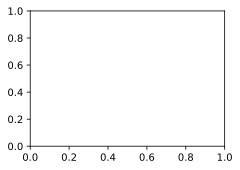

In [7]:
print("Starting training");
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer, decay_rate)

In [ ]:
print(mu.evaluate_accuracy(net,test_iter))
print(net);#Displays components of net, which happen to be used in order

In [ ]:
import cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)